# 時空間krigingを実装する
- kalman filterによる実装

## Model
$
x_t = x_{t-1} + w_t \\
y_t = F x_t + v_t \\
w_t\sim N(0, \Sigma_x),v_t\sim N(0, \Sigma_y) \\
$

In [2]:
import numpy as np

In [60]:
def kalman(y, x, SigP, SigX, SigY, F):
    '''
    カルマンフィルタ
    input:時点tの観測データ, 時点t-1の状態変数,
        分散共分散行列(状態変数, 観測・状態モデル), 状態変数と観測値の関係を表す行列
    output:
    '''
    
    # variance of state variable at t
    SigP0 = SigP + SigX
    
    # mean and variance of predicted likelihood of obs
    # y0_til = np.dot(F, x)
    SX_til = np.dot(np.dot(F, SigP0), F.T) + SigY
    SX_til_inv = np.linalg.inv(SX_til)
    
    # kalman gain
    K = np.dot(np.dot(SigP0, F.T), SX_til_inv)
    
    # update state
    # calculate mean
    y1_til = y - np.dot(F, x)
    x1 = x + np.dot(K, y1_til)
    # calculate variance
    dim = F.shape
    if type(F) == int:
        dim = [1]
    I = np.identity(dim[0])
    Sig = I - np.dot(K, F)
    SigP1 = np.dot(Sig, SigP0)
    
    # calculate predicted val
    pred = np.dot(F, x1)
    
    # calculate model marginal likelihood at t
    det = np.linalg.det(SX_til)
    var = np.dot(np.dot(y1_til.T, SX_til_inv), y1_til)
    logz = 0.5*(np.log(det) - var)
    
    # pred_val, pred_state, cov-mat of state, log-likeli, 
    return pred, x1, SigP1, logz, SX_til

## 一点の時系列データでテストしてみる

In [4]:
nt = 50  # number of time points
n = 1  # number of sample locations
nb = 1  # number of basis functions	
B = 1  # シミュレーションデータ生成用の行列（無視でok）
sigY = np.array(1)  # 観測モデルの誤差分散
sigX = np.array(1)  # 状態モデルの誤差分散
F = np.array(1)

In [5]:
def norm(sig):
    return np.random.normal(0, sig, 1)

In [6]:
x_list = []
y_list = []
for t in range(1, nt+1):
    if t == 1:
        e1 = norm(sigX)
    else:
        e1 = B*e0 + norm(sigX)
    x = B * e1 + norm(sigX)
    y = x + norm(sigY)
    
    x_list.append(x)
    y_list.append(y)
    e0 = e1

In [7]:
import matplotlib.pyplot as plt

In [8]:
index = [i for i in range(1, len(x_list) + 1)]

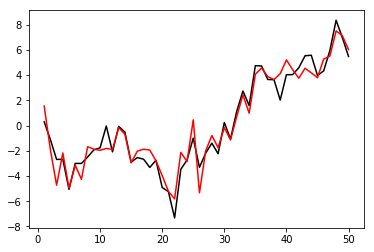

In [9]:
plt.plot(index, x_list, color='black')
plt.plot(index, y_list, color='red')

In [10]:
I = np.identity(n)
SigY = np.dot(sigY, I)
SigX = np.dot(sigX, I)
y_pred_list = []

In [11]:
for t in range(2, nt+1):
    if t == 2:
        x = y_list[0]
        SigP = I
    else:
        x = x1
        SigP = SigP1
    pred, x1, SigP1, logz, a \
    = kalman(y_list[t-1], x, SigP, SigX, SigY, F)
    y_pred_list.append(pred)

In [17]:
len(y_pred_list)

49

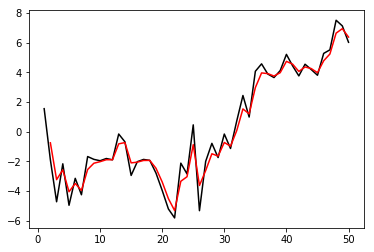

In [18]:
plt.plot(index, y_list, color='black')
plt.plot(index[1:], y_pred_list, color='red')

## 時空間データでテストしてみる

### シミュレーションデータ

In [30]:
import pandas as pd

In [28]:
# Settings
nt = 50  # 時点数
n = 50  # 地点数 
SigY = 1
SigX = 1
F = 1

In [36]:
Y = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/obs_variable_matrix.csv', index_col='Unnamed: 0')
Y.columns = [i for i in range(1, 51)]

In [37]:
coords = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/coordinates.csv', index_col='Unnamed: 0')
coords.columns = ['x', 'y']

In [93]:
C = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/simulation_data_covariance.csv', index_col='Unnamed: 0')
C.columns = [i for i in range(1, 51)]

In [44]:
Y.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
1,-0.763426,2.622124,1.874083,2.542185,-2.127825,-2.275798,0.563393,0.710846,0.391735,4.270546,...,1.842973,1.535547,-1.690706,-3.411947,-8.812684,-7.639371,-8.931781,-8.274470,-8.906630,-7.087467
2,1.330351,1.181800,2.829193,0.449903,-0.805213,-2.852126,0.130369,1.968104,2.632998,2.869091,...,6.110964,8.281103,1.918742,4.381729,3.539911,-1.976064,-0.674157,0.064696,-3.706775,-3.351284
3,1.896269,-0.894994,0.388368,-0.140967,-4.315400,-6.580025,-5.530214,-0.081541,-3.912439,-1.325068,...,-5.080373,-3.413901,-4.081062,-7.383311,-7.557372,-9.338766,-9.598783,-7.934065,-10.211029,-8.883541
4,0.218423,0.948807,-2.559636,-1.005910,-4.427630,-6.338799,-3.208813,-3.277373,-5.662542,-3.958622,...,-9.774783,-12.211212,-12.034127,-14.961022,-16.125339,-19.168398,-17.293310,-16.251890,-17.531638,-15.081929
5,-1.450014,-0.810102,1.620681,1.927428,0.660851,0.269727,4.694343,2.015782,6.662769,4.287389,...,-1.905253,-6.033669,-6.830704,-8.079764,-10.533101,-12.865716,-14.421968,-9.823012,-14.198642,-10.317001


In [96]:
Y = Y.values
coords = coords.values
C = C.values

### フィルタリング

In [108]:
# モデルのSetting
I = np.identity(n)
F = np.identity(n)
SigY = np.dot(SigY, I)
SigX = np.dot(SigX, C) + np.dot(SigX, I)
y_pred_list = []

In [109]:
for t in range(2, nt+1):
    if t == 2:
        x = np.repeat(np.mean(Y[:, 0]), n)
        SigP = np.identity(n)
    else:
        x = x1
        SigP = SigP1
    pred, x1, SigP1, logz, a \
    = kalman(Y[:, t-1], x, SigP, SigX, SigY, F)
    y_pred_list.append(pred)

### フィルタリング結果の確認

In [110]:
# 地点10の結果を確認
j = 10
y_at10 = Y[j-1, :]
y_pred_at10 = [preds[j-1] for preds in y_pred_list]

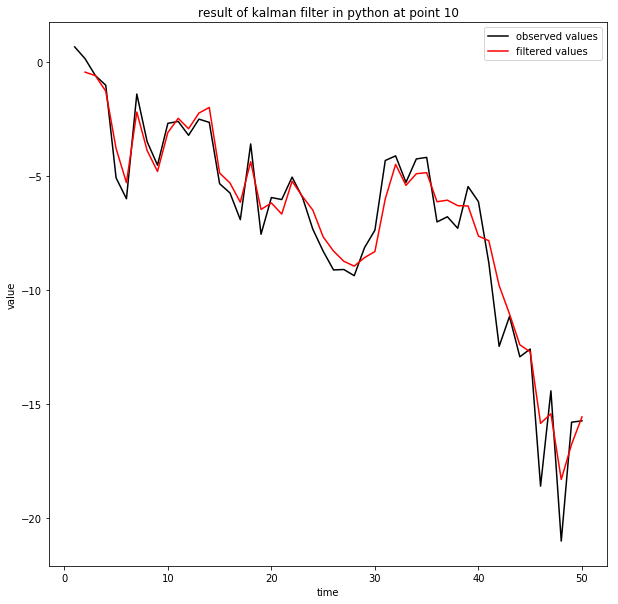

In [116]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(index, y_at10, color='black', label='observed values')
ax.plot(index[1:], y_pred_at10, color='red', label='filtered values')
ax.set_title('result of kalman filter in python at point 10')
ax.set_xlabel('time')
ax.set_ylabel('value')
ax.legend()

In [117]:
fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/res_kalmanfiter.png')